In [24]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
%matplotlib inline

In [25]:
# change defaults to be less ugly
mpl.rc('xtick', labelsize=14, color="#222222") 
mpl.rc('ytick', labelsize=14, color="#222222") 
mpl.rc('font', **{'family':'sans-serif','sans-serif':['Arial']})
mpl.rc('font', size=16)
mpl.rc('xtick.major', size=6, width=1)
mpl.rc('xtick.minor', size=3, width=1)
mpl.rc('ytick.major', size=6, width=1)
mpl.rc('ytick.minor', size=3, width=1)
mpl.rc('axes', linewidth=2, edgecolor="#222222", labelcolor="#222222")
mpl.rc('text', usetex=False, color="#222222")

In [26]:
import networkx as nx
import time

def load_graph(graph_file):
    print(f"Loading graph from {graph_file}...")
    start_time = time.time()
    
    # Load the graph
    G = nx.read_graphml(graph_file)
    
    # Convert position strings back into lists of integers
    for node in G.nodes:
        pos_str = G.nodes[node].get('pos', '')  # Use .get to avoid KeyError if 'pos' does not exist
        if pos_str:  # Check if the position string is not empty
            G.nodes[node]['pos'] = list(map(int, pos_str.split(',')))
        else:
            G.nodes[node]['pos'] = []

    end_time = time.time()
    print(f"Graph loaded in {end_time - start_time:.2f} seconds. It has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G


In [27]:
G = load_graph("spotify_AugWeek1.graphml")

Loading graph from spotify_AugWeek1.graphml...
Graph loaded in 17.50 seconds. It has 14495 nodes and 496547 edges.


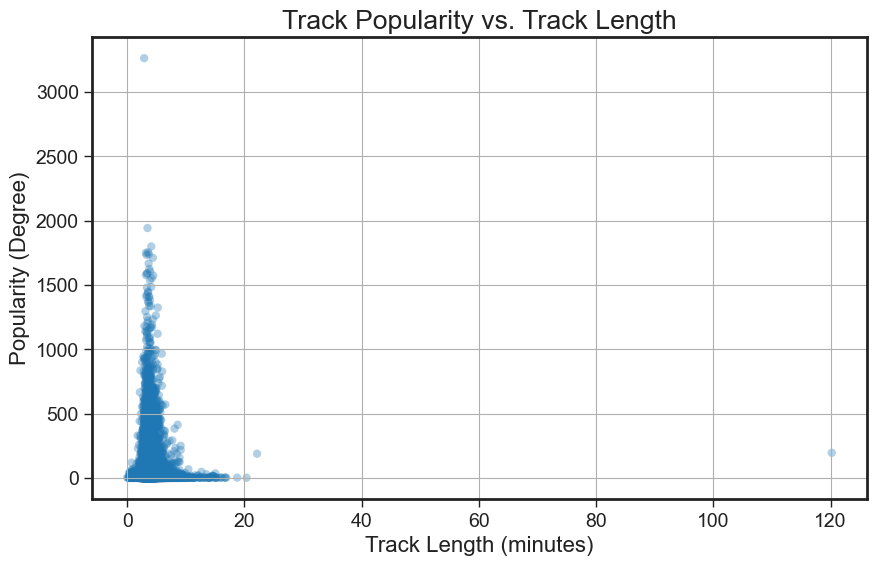

In [28]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming G is your graph object
# Initialize lists for degrees and durations
degrees = []
durations = []

# Iterate through each node to get its degree and duration
for node in G.nodes:
    degrees.append(G.degree(node))
    durations.append(G.nodes[node]['duration_ms'])

# Convert durations from milliseconds to minutes for a better scale
durations_minutes = [duration / 60000 for duration in durations]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(durations_minutes, degrees, alpha=0.35, edgecolors='none')
plt.title('Track Popularity vs. Track Length')
plt.xlabel('Track Length (minutes)')
plt.ylabel('Popularity (Degree)')
plt.grid(True)
plt.show()


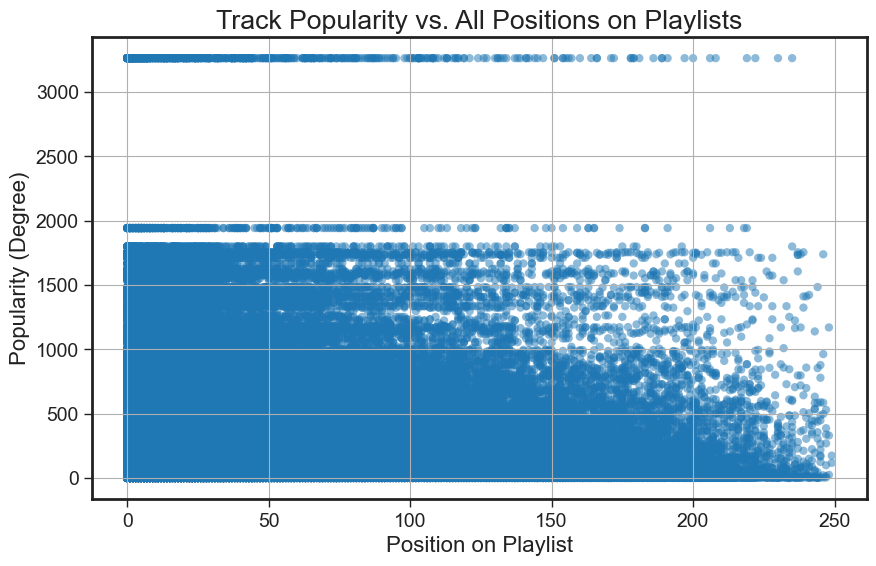

In [29]:
# Initialize lists for degrees and positions
all_degrees = []
all_positions = []

# Iterate through each node to get its degree and all positions
for node in G.nodes:
    node_degree = G.degree(node)
    positions = G.nodes[node]['pos']  # This is now a list of positions
    
    # Append the node's degree for each position it has
    for pos in positions:
        all_degrees.append(node_degree)
        all_positions.append(pos)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(all_positions, all_degrees, alpha=0.5, edgecolors='none')
plt.title('Track Popularity vs. All Positions on Playlists')
plt.xlabel('Position on Playlist')
plt.ylabel('Popularity (Degree)')
plt.grid(True)
plt.show()


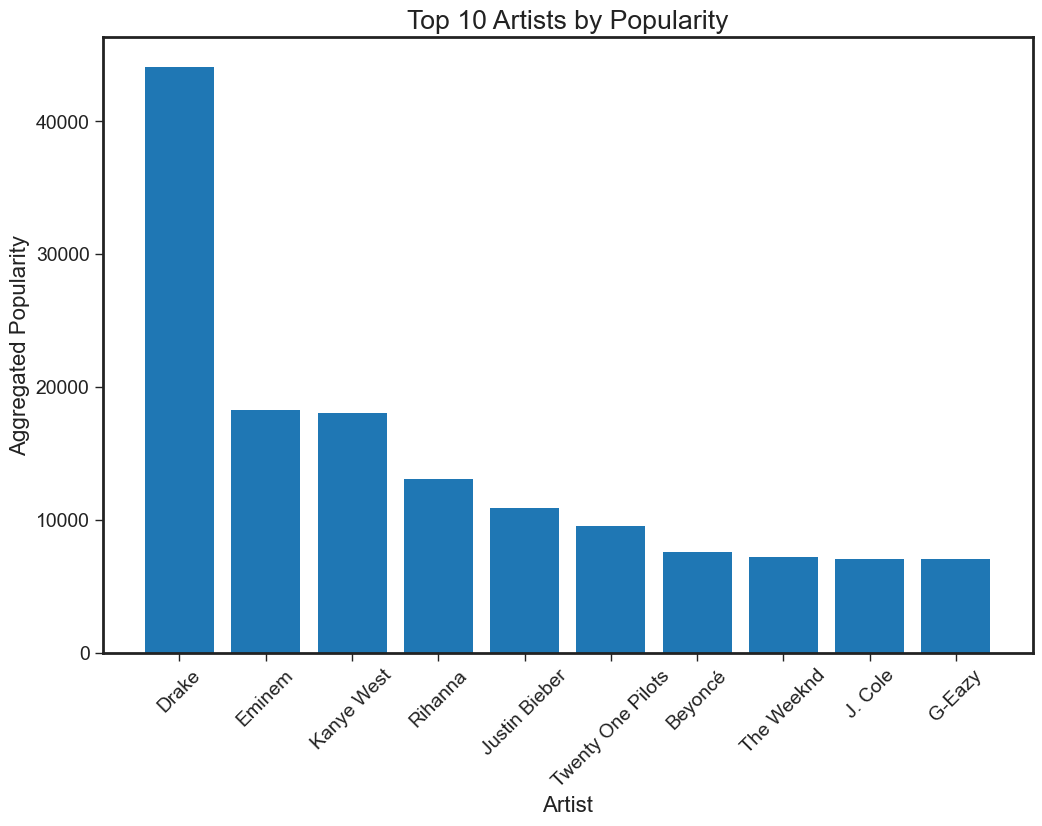

In [30]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Aggregate popularity by artist
artist_popularity = defaultdict(int)
for node in G.nodes:
    artist_popularity[G.nodes[node]['artist_name']] += G.degree(node)

# Sort artists by their aggregated popularity
sorted_artists = sorted(artist_popularity.items(), key=lambda x: x[1], reverse=True)

# Select the top N artists
top_n = 10
top_artists, top_popularities = zip(*sorted_artists[:top_n])

plt.figure(figsize=(12, 8))
plt.bar(top_artists, top_popularities)
plt.title(f'Top {top_n} Artists by Popularity')
plt.xlabel('Artist')
plt.ylabel('Aggregated Popularity')
plt.xticks(rotation=45)
plt.show()


In [ ]:
def degree_distribution_stats(G):
    N = len(G)
    L = G.size()
    degrees = [G.degree(node) for node in G]
    kmin = min(degrees)
    kmax = max(degrees)

    print("Number of nodes: ", N)
    print("Number of edges: ", L)
    print()
    print("Average degree: ", 2*L/N)
    print("Average degree (alternate calculation)", np.mean(degrees))
    print()
    print("Minimum degree: ", kmin)
    print("Maximum degree: ", kmax)

In [43]:
# Function to plot a degree distribution graph (P(k) vs k graph)

def plot_degree_dist(G, title="Degree Distribution"):
    degrees = [G.degree(n) for n in G.nodes()]
    kmin = min(degrees)
    kmax = max(degrees)
    
    # Specify the number of bins you want
    num_bins = 20  # You can adjust this number based on your preference or dataset size
    
    if kmin > 0:
        bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num_bins)
    else:
        # Adding .2 to include kmax in the range if kmin is 0
        bin_edges = np.logspace(0, np.log10(kmax) + .2, num_bins)
    
    density, _ = np.histogram(degrees, bins=bin_edges, density=True)

    fig = plt.figure(figsize=(6, 4))

    log_be = np.log10(bin_edges)
    x = 10 ** ((log_be[1:] + log_be[:-1]) / 2)  # Compute geometric mean of bin edges for plotting
    plt.loglog(x, density, marker='o', linestyle='none', color='g')
    plt.xlabel(r"Degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)
    plt.title(title)

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    plt.show()

Number of nodes:  14495
Number of edges:  496547

Average degree:  68.51286650569162
Average degree (alternate calculation) 68.51286650569162

Minimum degree:  0
Maximum degree:  3263


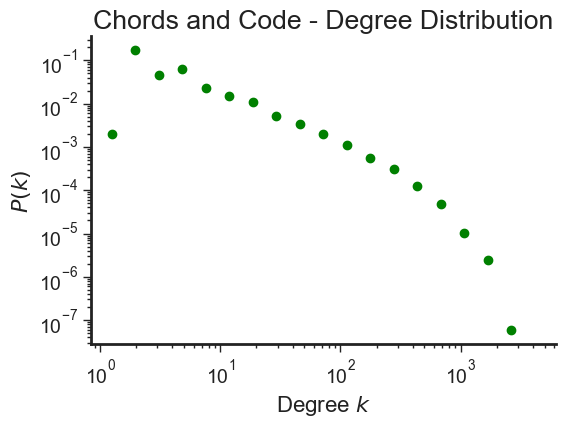

In [44]:
degree_distribution_stats(G)
plot_degree_dist(G, "Chords and Code - Degree Distribution")

# Clustering Coefficient and Shortest Path

In [36]:
# Find the clustering coefficient for our new filtered graph H
C = np.mean(list(nx.clustering(G).values()))
print("Average Clustering Coefficient: ", C)

Average Clustering Coefficient:  0.7537348751646876


Now find it for the largest component, to ensure we are calculating it for a component that is entirely connected

In [40]:
largest_cc = max(nx.connected_components(G), key=len)

# Create a subgraph of G containing only the nodes in largest_cc
G_largest = G.subgraph(largest_cc)

In [42]:
# Calculate clustering coefficient
# Calculate the shortest path
C = np.mean(list(nx.clustering(G_largest).values()))
d = nx.average_shortest_path_length(G_largest,weight=None)

print("Average Clustering Coefficient: ", C)
print("Average Shortest Path: ", d)

KeyboardInterrupt: 

# Degree Preservation Analysis (ER and Double-Edge Swap)

In [ ]:
GN = len(G.nodes()) # G.number_of_nodes()
max_L = GN*(GN-1)/2
actual_L = len(G.edges())
p = actual_L/max_L

clustering_ER = []
short_path_ER = []

for i in range(100): # 1000 is better
    
    ER = nx.erdos_renyi_graph(GN, p, directed=False)
    C_ER = np.mean(list(nx.clustering(ER).values()))
    if nx.is_connected(ER)==True:
        d_ER = nx.average_shortest_path_length(ER,weight=None)
    clustering_ER.append(C_ER)
    short_path_ER.append(d_ER)
    
print(np.mean(clustering_ER))
print(np.std(clustering_ER))

print(np.mean(short_path_ER))
print(np.std(short_path_ER))

KeyboardInterrupt: 

In [ ]:
# Calculating metrics for a Degree Preservation Graph

DP = G.copy()

clustering_DP = []
short_path_DP = []

for i in range(100): # 1000 is better
    
    nx.double_edge_swap(DP,nswap=10*G.number_of_edges(),max_tries=100000)
    C_DP = np.mean(list(nx.clustering(DP).values()))
    if nx.is_connected(DP)==True:
        d_DP = nx.average_shortest_path_length(DP,weight=None)
    clustering_DP.append(C_DP)
    short_path_DP.append(d_DP)
    
print(np.mean(clustering_DP))
print(np.std(clustering_DP))

print(np.mean(short_path_DP))
print(np.std(short_path_DP))

In [ ]:
fig = plt.figure(figsize=(6,4))

plt.boxplot([clustering_ER,clustering_DP], positions=[1,2])
plt.plot(3,C,'r',marker='+',markersize=15)
ax = plt.gca()
ax.set_xticks([1,2,3],labels=['ER','DP','Spotify Playlists'])
plt.ylabel('Clustering')
plt.xlim([0.5,3.5])
plt.show()